# Importing Libraries

In [ ]:
# Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings("ignore")


# Reading the Datafile

In [ ]:
# Load the data
jj_data = pd.read_csv("/content/drive/MyDrive/ML Work/Assignment /jj.csv")
amzn_data = pd.read_csv("/content/drive/MyDrive/ML Work/Assignment /AMZN.csv")

In [ ]:
jj_data.head()

,date,data
0,1960-01-01,0.71
1,1960-04-01,0.63
2,1960-07-02,0.85
3,1960-10-01,0.44
4,1961-01-01,0.61


In [ ]:
# Rename the 'data' column to 'Sales'
jj_data .columns = ['Date', 'Sales']
# Set 'Date' as the index
jj_data .set_index('Date', inplace=True)
# Convert the index to datetime
jj_data .index = pd.to_datetime(jj_data .index)
# View result
print(jj_data )

            Sales
Date             
1960-01-01   0.71
1960-04-01   0.63
1960-07-02   0.85
1960-10-01   0.44
1961-01-01   0.61
...           ...
1979-10-01   9.99
1980-01-01  16.20
1980-04-01  14.67
1980-07-02  16.02
1980-10-01  11.61

[84 rows x 1 columns]


# Amazon Data

In [ ]:
# Select only 'Date' and 'Close' columns for analysis
amzn_data = amzn_data[['Date', 'Close']]
# Convert the 'Date' column to datetime format
amzn_data['Date'] = pd.to_datetime(amzn_data['Date'])
# Set 'Date' as the index for time series operations
amzn_data.set_index('Date', inplace=True)

# Time Series Graph

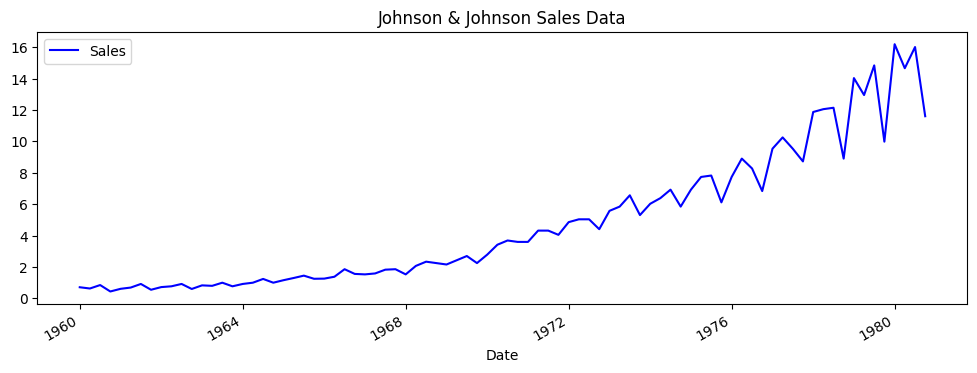

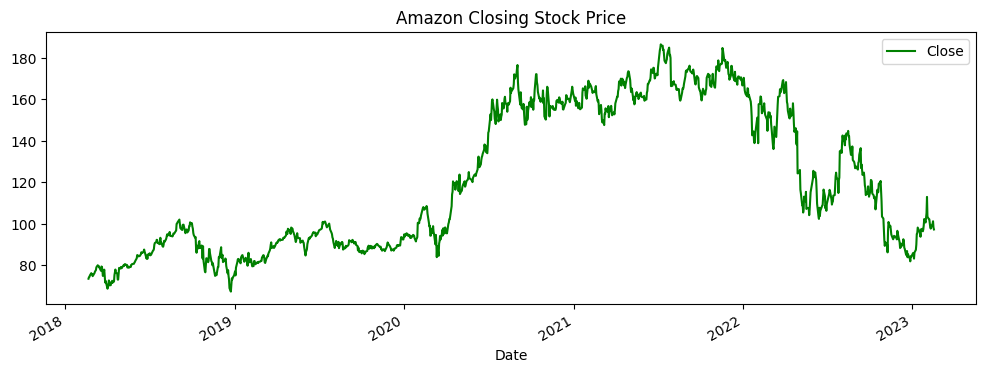

In [ ]:
# Plot Johnson & Johnson sales time series in blue
jj_data.plot(title='Johnson & Johnson Sales Data', figsize=(12, 4), color='blue')
plt.show()

# Plot Amazon closing stock price time series in green
amzn_data.plot(title='Amazon Closing Stock Price', figsize=(12, 4), color='green')
plt.show()


# Stationarity Testing and Differencing

In [ ]:
# Augmented Dickey-Fuller (ADF) Test for stationarity
def adf_test(series, title=''):
    print(f'ADF Test: {title}')
    result = adfuller(series.dropna(), autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Stationary' if result[1] < 0.05 else 'Non-stationary')

# Run ADF test on Johnson & Johnson Sales data
adf_test(jj_data ['Sales'], 'JJ Sales')

# Run ADF test on Amazon Closing Stock Price data
adf_test(amzn_data['Close'], 'Amazon Close')

ADF Test: JJ Sales
ADF Statistic: 2.7420165734574744
p-value: 1.0
Non-stationary
ADF Test: Amazon Close
ADF Statistic: -1.6578089913331728
p-value: 0.45297105465166737
Non-stationary


# first-order differencing

In [ ]:
# Apply first-order differencing to make the series stationary
jj_diff = jj_data['Sales'].diff().dropna()
amzn_diff = amzn_data['Close'].diff().dropna()

# Re-run ADF test on differenced series
adf_test(jj_diff, 'JJ Sales - Differenced')
adf_test(amzn_diff, 'Amazon Close - Differenced')

ADF Test: JJ Sales - Differenced
ADF Statistic: -0.40740976363804615
p-value: 0.9088542416911305
Non-stationary
ADF Test: Amazon Close - Differenced
ADF Statistic: -36.25077933242776
p-value: 0.0
Stationary


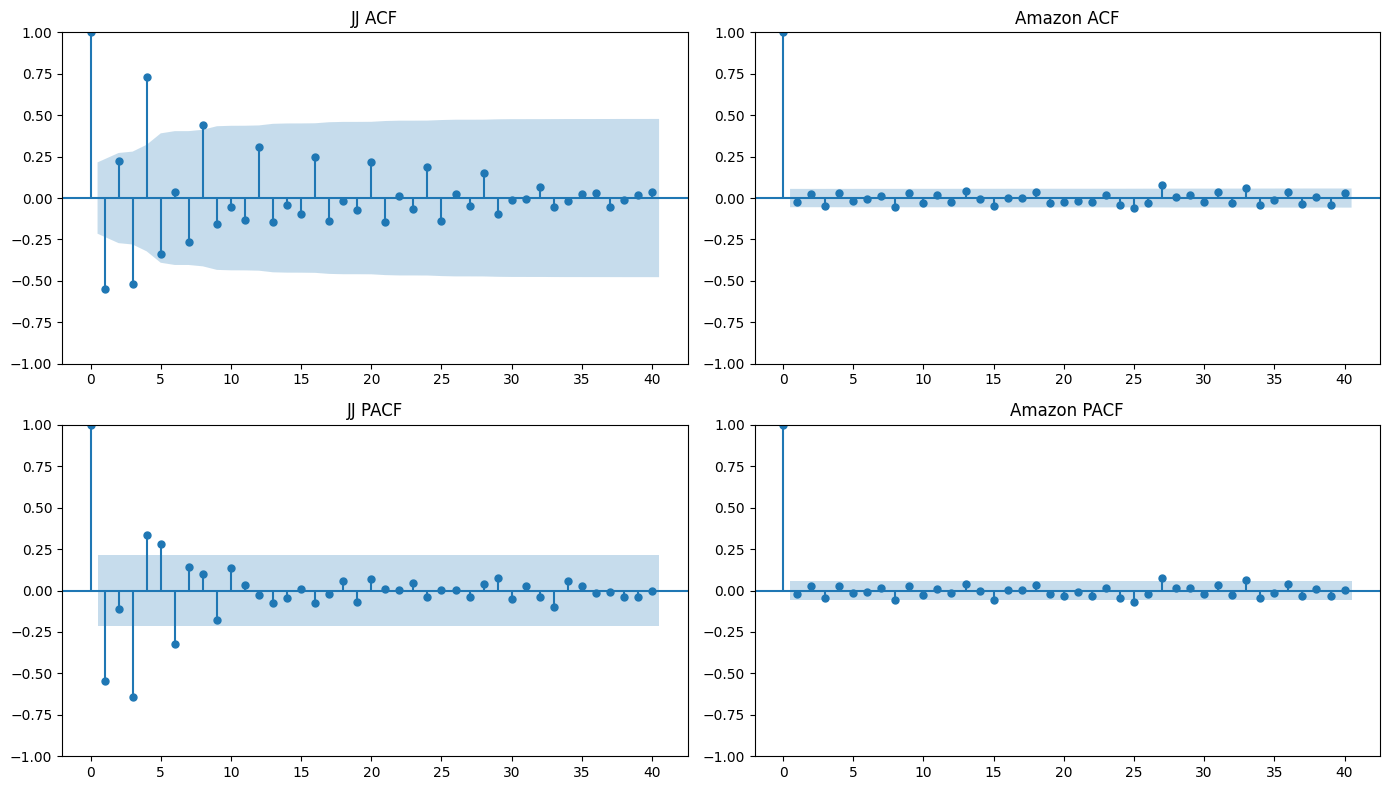

In [ ]:
# ACF and PACF plots
fig, ax = plt.subplots(2, 2, figsize=(14, 8))

# JJ ACF and PACF
plot_acf(jj_diff, ax=ax[0, 0], lags=40)
ax[0, 0].set_title("JJ ACF")

plot_pacf(jj_diff, ax=ax[1, 0], lags=40, method='ywm')  # use 'ywm' for stability
ax[1, 0].set_title("JJ PACF")

# Amazon ACF and PACF
plot_acf(amzn_diff, ax=ax[0, 1], lags=40)
ax[0, 1].set_title("Amazon ACF")

plot_pacf(amzn_diff, ax=ax[1, 1], lags=40, method='ywm')
ax[1, 1].set_title("Amazon PACF")

plt.tight_layout()
plt.show()

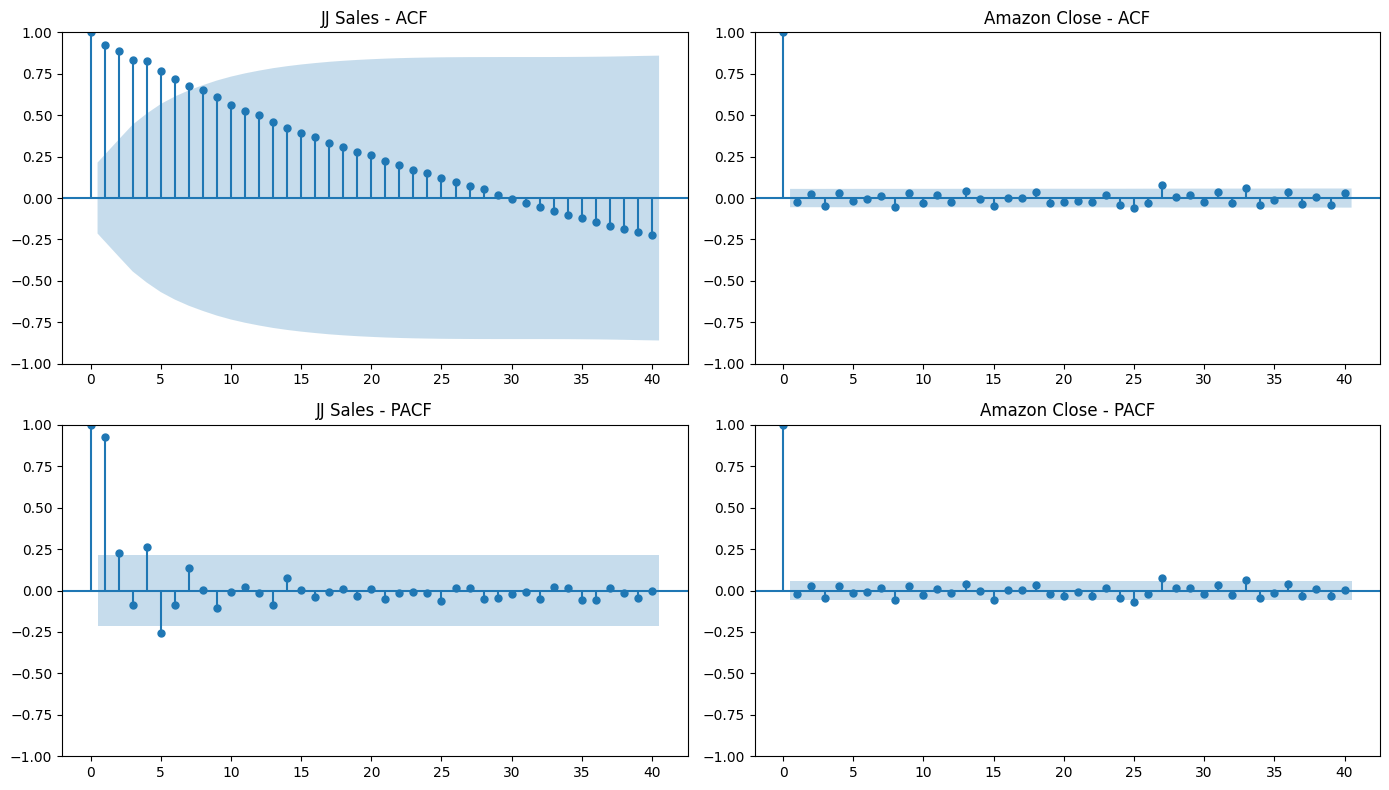

In [ ]:
# Plot ACF and PACF for both JJ and Amazon differenced series
fig, ax = plt.subplots(2, 2, figsize=(14, 8))

# ACF and PACF for Johnson & Johnson Sales (1st difference)
plot_acf(jj_data, ax=ax[0, 0], lags=40)
ax[0, 0].set_title("JJ Sales - ACF")

plot_pacf(jj_data, ax=ax[1, 0], lags=40, method='ywm')  # 'ywm' is more stable
ax[1, 0].set_title("JJ Sales - PACF")

# ACF and PACF for Amazon Close (1st difference)
plot_acf(amzn_diff, ax=ax[0, 1], lags=40)
ax[0, 1].set_title("Amazon Close - ACF")

plot_pacf(amzn_diff, ax=ax[1, 1], lags=40, method='ywm')
ax[1, 1].set_title("Amazon Close - PACF")

plt.tight_layout()
plt.show()


# ARIMA (ARMA) Modelling and Forecast

In [ ]:
# Fit ARIMA model to Johnson & Johnson sales data
jj_model = ARIMA(jj_data['Sales'], order=(1, 1, 1))  # Tune (p,d,q) using AIC/BIC
jj_fit = jj_model.fit()
print(jj_fit.summary())

# Fit ARIMA model to Amazon closing stock price
amzn_model = ARIMA(amzn_data['Close'], order=(1, 1, 1))  # Tune (p,d,q) using AIC/BIC
amzn_fit = amzn_model.fit()
print(amzn_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   84
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -128.371
Date:                Fri, 11 Apr 2025   AIC                            262.742
Time:                        11:07:40   BIC                            269.998
Sample:                             0   HQIC                           265.657
                                 - 84                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3277      0.090     -3.657      0.000      -0.503      -0.152
ma.L1         -0.4313      0.093     -4.662      0.000      -0.613      -0.250
sigma2         1.2819      0.164      7.814      0.0

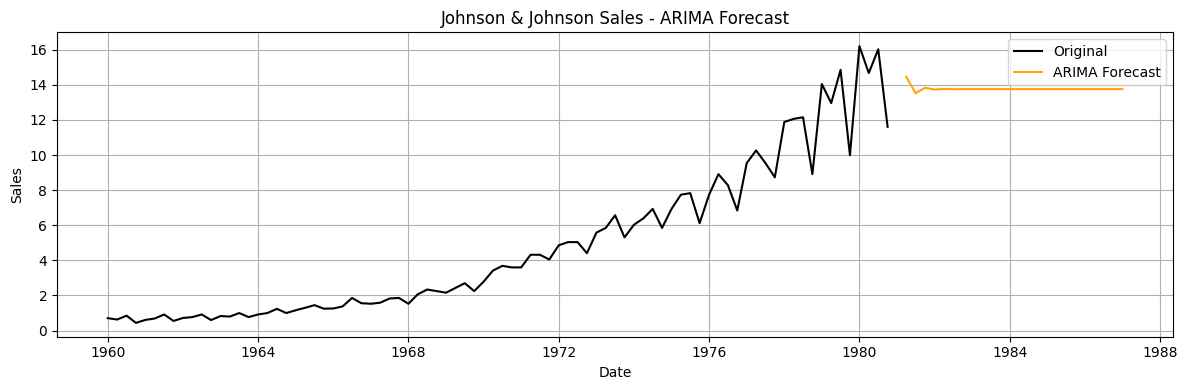

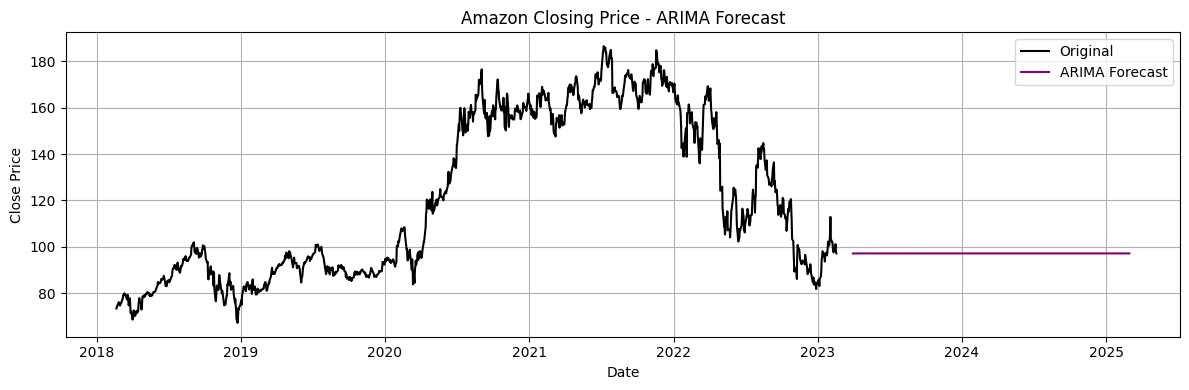

In [ ]:
# -----------------------------
# ARIMA Forecast Plots with Custom Colors
# -----------------------------
# Forecast 24 months ahead
jj_forecast = jj_fit.forecast(steps=24)
amzn_forecast = amzn_fit.forecast(steps=24)

# Plot Johnson & Johnson Sales Forecast (Quarterly)
plt.figure(figsize=(12, 4))
plt.plot(jj_data['Sales'], label='Original', color='black')
plt.plot(pd.date_range(jj_data.index[-1], periods=25, freq='Q')[1:], jj_forecast, label='ARIMA Forecast', color='orange')
plt.title('Johnson & Johnson Sales - ARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Amazon Closing Price Forecast (Monthly)
plt.figure(figsize=(12, 4))
plt.plot(amzn_data['Close'], label='Original', color='black')
plt.plot(pd.date_range(amzn_data.index[-1], periods=25, freq='M')[1:], amzn_forecast, label='ARIMA Forecast', color='purple')
plt.title('Amazon Closing Price - ARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Neural Network Forecasting (LSTM / GRU)

In [ ]:
# -----------------------------
# Prepare data for RNN
# -----------------------------
def prepare_data(series, n_lags=12):
    X, y = [], []
    for i in range(n_lags, len(series)):
        X.append(series[i - n_lags:i])
        y.append(series[i])
    return np.array(X), np.array(y)

# -----------------------------
# Normalize data
# -----------------------------
# Johnson & Johnson
scaler_jj = MinMaxScaler()
jj_scaled = scaler_jj.fit_transform(jj_data['Sales'].values.reshape(-1, 1))
X_jj, y_jj = prepare_data(jj_scaled)

# Amazon
scaler_amzn = MinMaxScaler()
amzn_scaled = scaler_amzn.fit_transform(amzn_data['Close'].values.reshape(-1, 1))
X_amzn, y_amzn = prepare_data(amzn_scaled)

# Reshape for RNN [samples, timesteps, features]
X_jj = X_jj.reshape((X_jj.shape[0], X_jj.shape[1], 1))
X_amzn = X_amzn.reshape((X_amzn.shape[0], X_amzn.shape[1], 1))

In [ ]:
# Build model (LSTM or GRU)
# -----------------------------
def build_model(input_shape, model_type='LSTM'):
    model = Sequential()
    if model_type == 'LSTM':
        model.add(LSTM(64, return_sequences=False, input_shape=input_shape))
    elif model_type == 'GRU':
        model.add(GRU(64, return_sequences=False, input_shape=input_shape))
    else:
        raise ValueError("model_type must be 'LSTM' or 'GRU'")

    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

In [ ]:
def train_forecast(X, y, scaler, model_type='LSTM', forecast_steps=24):
    # Build and compile model
    model = build_model((X.shape[1], 1), model_type)

    # Early stopping to prevent overfitting
    early_stop = EarlyStopping(patience=10, restore_best_weights=True)

    # Train the model
    model.fit(
        X, y,
        epochs=100,
        batch_size=16,
        validation_split=0.2,
        callbacks=[early_stop],
        verbose=0
    )

    # Forecasting future values
    last_seq = X[-1]  # last observed window
    preds = []

    for _ in range(forecast_steps):
        pred = model.predict(last_seq.reshape(1, -1, 1), verbose=0)[0]
        preds.append(pred)
        last_seq = np.append(last_seq[1:], pred).reshape(-1, 1)

    # Inverse transform predictions to original scale
    preds = scaler.inverse_transform(np.array(preds).reshape(-1, 1)).flatten()
    return preds

In [ ]:
# Johnson & Johnson Forecasts
print("Training LSTM for Johnson & Johnson...")
jj_lstm_forecast = train_forecast(X_jj, y_jj, scaler_jj, model_type='LSTM')

print("Training GRU for Johnson & Johnson...")
jj_gru_forecast = train_forecast(X_jj, y_jj, scaler_jj, model_type='GRU')

# Amazon Forecasts
print("Training LSTM for Amazon...")
amzn_lstm_forecast = train_forecast(X_amzn, y_amzn, scaler_amzn, model_type='LSTM')

print("Training GRU for Amazon...")
amzn_gru_forecast = train_forecast(X_amzn, y_amzn, scaler_amzn, model_type='GRU')

Training LSTM for Johnson & Johnson...
Training GRU for Johnson & Johnson...
Training LSTM for Amazon...
Training GRU for Amazon...


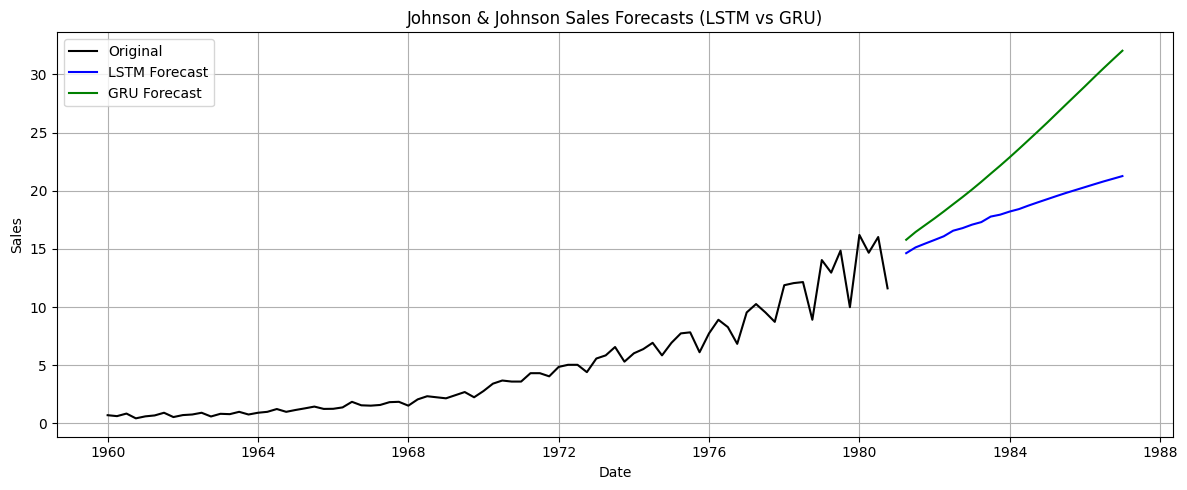

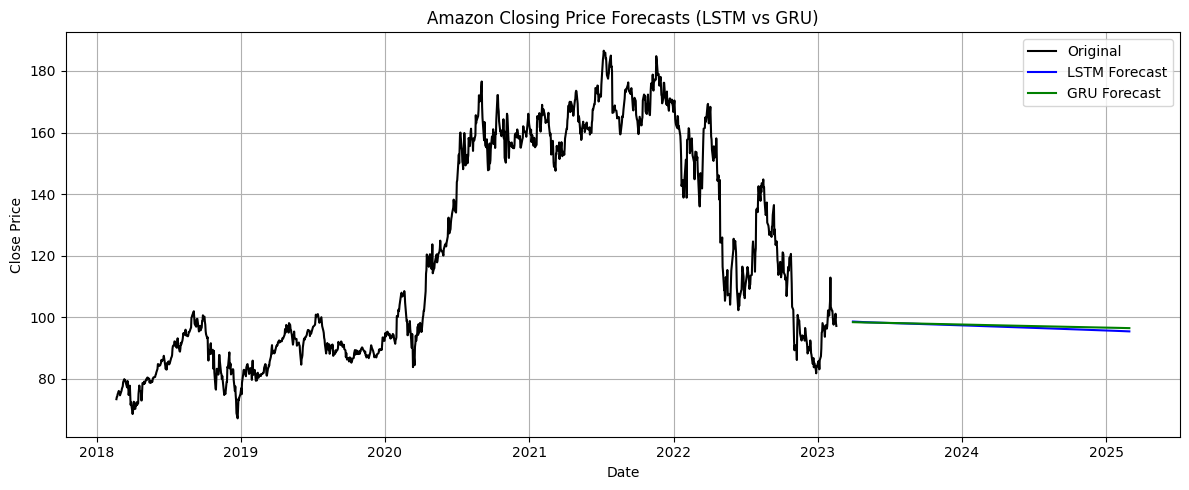

In [ ]:
# -----------------------------
# Plot Forecasts
# -----------------------------

# Johnson & Johnson Forecasts
plt.figure(figsize=(12, 5))
plt.plot(jj_data['Sales'], label='Original', color='black')
plt.plot(pd.date_range(jj_data.index[-1], periods=25, freq='Q')[1:], jj_lstm_forecast, label='LSTM Forecast', color='blue')
plt.plot(pd.date_range(jj_data.index[-1], periods=25, freq='Q')[1:], jj_gru_forecast, label='GRU Forecast', color='green')
plt.title('Johnson & Johnson Sales Forecasts (LSTM vs GRU)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Amazon Forecasts
plt.figure(figsize=(12, 5))
plt.plot(amzn_data['Close'], label='Original', color='black')
plt.plot(pd.date_range(amzn_data.index[-1], periods=25, freq='M')[1:], amzn_lstm_forecast, label='LSTM Forecast', color='blue')
plt.plot(pd.date_range(amzn_data.index[-1], periods=25, freq='M')[1:], amzn_gru_forecast, label='GRU Forecast', color='green')
plt.title('Amazon Closing Price Forecasts (LSTM vs GRU)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# -----------------------------
# Evaluation function
# -----------------------------
def evaluate(true, pred, model_name="Model"):
    mse = mean_squared_error(true, pred)
    mae = mean_absolute_error(true, pred)
    print(f"{model_name} -> MSE: {mse:.4f}, MAE: {mae:.4f}")

# Create slices of true values (last 24 steps)
jj_true = jj_data['Sales'][-24:].values
amzn_true = amzn_data['Close'][-24:].values

# -----------------------------
# Johnson & Johnson
# -----------------------------
evaluate(jj_true, jj_lstm_forecast, "JJ LSTM")
evaluate(jj_true, jj_gru_forecast, "JJ GRU")

# -----------------------------
# Amazon
# -----------------------------
evaluate(amzn_true, amzn_lstm_forecast, "Amazon LSTM")
evaluate(amzn_true, amzn_gru_forecast, "Amazon GRU")

JJ LSTM -> MSE: 61.4291, MAE: 7.6529
JJ GRU -> MSE: 175.9177, MAE: 12.9399
Amazon LSTM -> MSE: 25.6768, MAE: 3.9461
Amazon GRU -> MSE: 22.3204, MAE: 3.5251
